# quant-econ Solutions: The Kalman Filter

Solutions for http://quant-econ.net/jl/kalman.html

In [1]:
using QuantEcon
using PyPlot

## Exercise 1

/home/chase/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


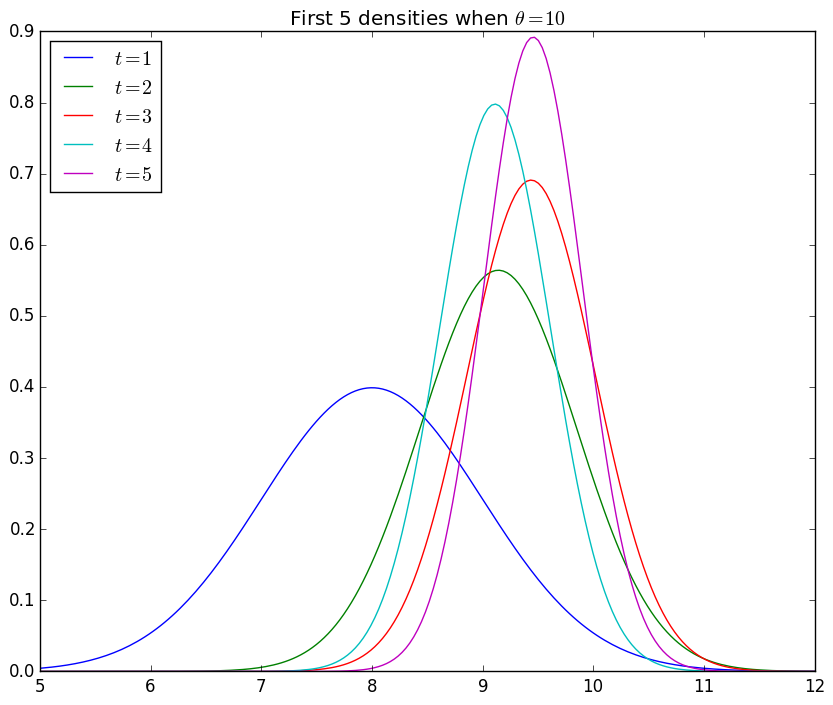

In [2]:
import Distributions: Normal, pdf
# == Parameters == #

theta = 10
A, G, Q, R = 1.0, 1.0, 0.0, 1.0
x_hat_0, Sigma_0 = 8.0, 1.0

# == Initialize Kalman filter == #

kalman = Kalman(A, G, Q, R)
set_state!(kalman, x_hat_0, Sigma_0)
# == Run == #

N = 5
fig, ax = subplots(figsize=(10,8))
xgrid = linspace(theta - 5, theta + 2, 200)
for i=1:N
    # Record the current predicted mean and variance, and plot their densities
    m, v = kalman.cur_x_hat, kalman.cur_sigma
    ax[:plot](xgrid, pdf(Normal(m, sqrt(v)), xgrid), 
              label=LaTeXString("\$t=$i\$"))

    # Generate the noisy signal
    y = theta + randn()

    # Update the Kalman filter
    update!(kalman, y)
end

ax[:set_title](LaTeXString("First $N densities when \$\\theta = $theta\$"))
ax[:legend](loc="upper left");
fig[:show]()

## Exercise 2

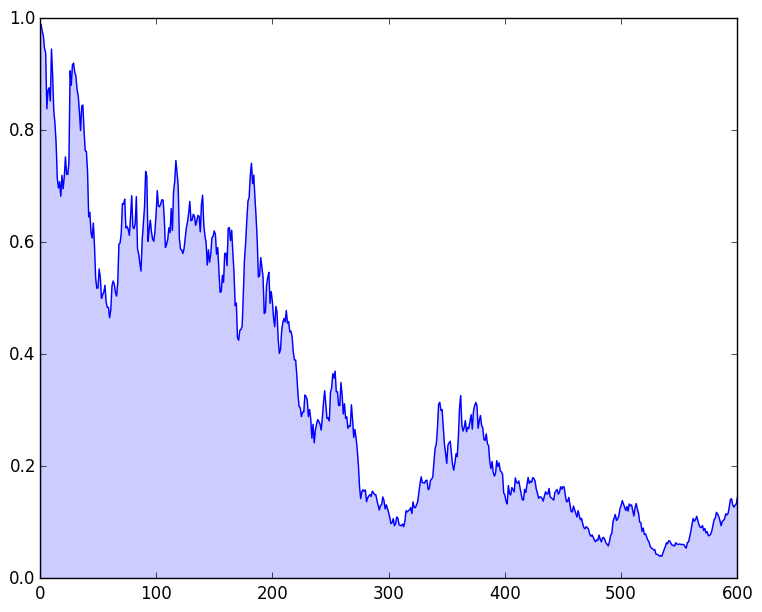

In [3]:
srand(42)  # reproducible results
epsilon = 0.1
kalman = Kalman(A, G, Q, R)
set_state!(kalman, x_hat_0, Sigma_0)

nodes, weights = qnwlege(21, theta-epsilon, theta+epsilon)

T = 600
z = Array(Float64, T)
for t=1:T
    # Record the current predicted mean and variance, and plot their densities
    m, v = kalman.cur_x_hat, kalman.cur_sigma
    dist = Normal(m, sqrt(v))
    integral = do_quad((x)->pdf(dist, x), nodes, weights)
    z[t] = 1. - integral
    # Generate the noisy signal and update the Kalman filter
    update!(kalman, theta + randn())
end

fig, ax = subplots(figsize=(9, 7))
ax[:set_ylim](0, 1)
ax[:set_xlim](0, T)
ax[:plot](1:T, z)
ax[:fill_between](1:T, zeros(T), z, color="blue", alpha=0.2);

fig[:show]()

## Exercise 3

/home/chase/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Eigenvalues of A:
[0.8999999999999999,-0.10000000000000003]
Stationary prediction error variance:
[0.4032910794778669 0.10507180275061762
 0.10507180275061762 0.41061709375220456]


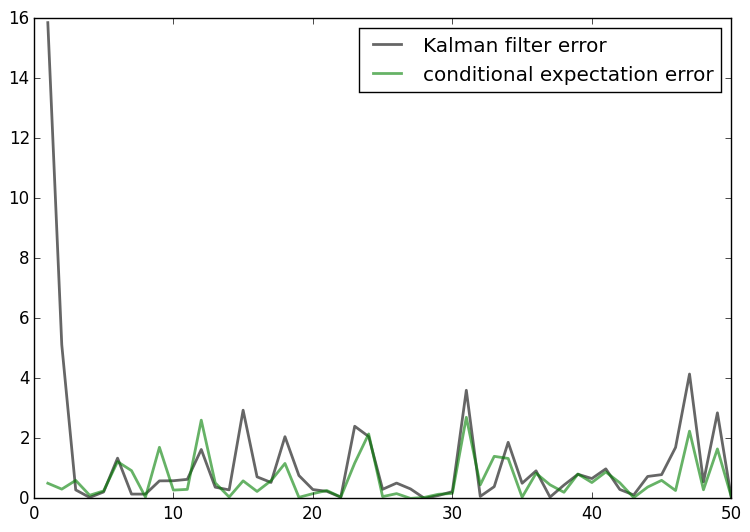

In [4]:
import Distributions: MultivariateNormal, rand
srand(41)  # reproducible results

# === Define A, Q, G, R === #
G = eye(2)
R = 0.5 .* G
A = [0.5 0.4
     0.6 0.3]
Q = 0.3 .* G

# === Define the prior density === #
Sigma = [0.9 0.3
         0.3 0.9]
x_hat = [8, 8]''

# === Initialize the Kalman filter === #
kn = Kalman(A, G, Q, R)
set_state!(kn, x_hat, Sigma)

# === Set the true initial value of the state === #
x = zeros(2)

# == Print eigenvalues of A == #
println("Eigenvalues of A:\n$(eigvals(A))")

# == Print stationary Sigma == #
S, K = stationary_values(kn)
println("Stationary prediction error variance:\n$S")

# === Generate the plot === #
T = 50
e1 = Array(Float64, T)
e2 = Array(Float64, T)
for t=1:T
    # == Generate signal and update prediction == #
    dist = MultivariateNormal(G*x, R)
    y = rand(dist)
    update!(kn, y)

    # == Update state and record error == #
    Ax = A * x
    x = rand(MultivariateNormal(Ax, Q))
    e1[t] = sum((x - kn.cur_x_hat).^2)
    e2[t] = sum((x - Ax).^2)
end

fig, ax = subplots(figsize=(9,6))
ax[:plot](1:T, e1, "k-", lw=2, alpha=0.6, label="Kalman filter error")
ax[:plot](1:T, e2, "g-", lw=2, alpha=0.6, label="conditional expectation error")
ax[:legend]();

fig[:show]()